<a href="https://colab.research.google.com/github/Antony-gitau/Airline_ticket_price_prediction/blob/main/cv_assignment_attempted3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Training basic CNNs from scratch

- Load the 50k training sample and the 10k testing samples
- Set up a basic CNN model and train it from scratch.
- Experiment with different architectures and regularisation techniques.

In [30]:
%%capture
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
!pip install torchinfo
from torchinfo import summary
from torchvision import transforms, models

In [25]:
#parameters that I can alter to affect performance
BATCH_SIZE = 8
NUM_WORKERS = 2
LEARNING_RATE = 0.01
MOMENTUM = 0.9 #can help optimizer converge
EPOCHS = 20

## Loading and normalizing CIFAR10 data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Define the split ratio (80% train, 20% validation)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

# Split the dataset into training and validation sets
train_subset, val_subset = random_split(trainset, [train_size, val_size])


trainloader = DataLoader(train_subset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)
valloader = DataLoader(val_subset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=NUM_WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


Now that we have created a dataloader for a train, validation and test sets, we can visualize some of the data.

The cell below, randomly iterates through the training loader and then plots training images, and their labels. I am ploting images of the length of one batch size.

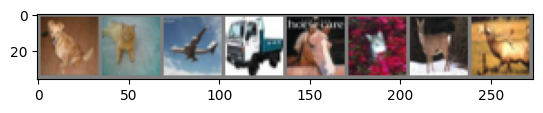

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

classes = ("plain", "car", "bird","cat", "deer", "dog", "frog",
           "horse", "ship", "truck")

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(BATCH_SIZE)))


In [6]:
print(f"Shape of the input images: {images.shape}, batch size, channel, height, and width respectively")


dog   cat   plain truck horse cat   deer  deer 
Shape of the input images: torch.Size([8, 3, 32, 32]), batch size, channel, height, and width respectively


# Define a basic CNN

Convolution 1 will have 3 input layers, 64 outputs, and a kernel size of 2 * 2

- [Polo club group](https://poloclub.github.io/cnn-explainer/) have a visual of how different parameters affect CNN model operations.

- This [paper](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) has some guidelines to convolution arithmetics

- I used some inspiration from [cs231](https://cs231n.github.io/convolutional-networks/) course to decide on the paramters of my model.

Defaults:
- By default, PyTorch's Conv2d uses a stride of 1 and no padding.

In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
       # first conv-ReLU block then max pool
        x = F.relu(self.conv1(x)) # 32x32x3 -> 32x32x64
        x = F.relu(self.conv2(x)) # 32x32x3 -> 32x32x64
        x = self.pool(x) # 32x32x3 -> 16x16x64

        # second conv-ReLU block then max pool
        x = F.relu(self.conv3(x)) # 16x16x64 -> 16x16x128
        x = F.relu(self.conv4(x)) # 16x16x128 -> 16x16x128
        x = self.pool(x) # 8x8x128

        # flatten dimensions
        x = torch.flatten(x, 1) #  8 * 8 * 128

        # fully connected + ReLU
        x = F.relu(self.fc1(x)) # 8 * 8 * 128 -> 120
        x = F.relu(self.fc2(x)) # 120 -> 84

        # Output layer
        x = self.fc3(x) # 84-> 10
        return x


In [18]:
net_01 = Net()
print(net_01)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = net_01.to(device)

In [20]:
summary(loaded_model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [8, 10]                   --
├─Conv2d: 1-1                            [8, 64, 32, 32]           1,792
├─Conv2d: 1-2                            [8, 64, 32, 32]           36,928
├─MaxPool2d: 1-3                         [8, 64, 16, 16]           --
├─Conv2d: 1-4                            [8, 128, 16, 16]          73,856
├─Conv2d: 1-5                            [8, 128, 16, 16]          147,584
├─MaxPool2d: 1-6                         [8, 128, 8, 8]            --
├─Linear: 1-7                            [8, 120]                  983,160
├─Linear: 1-8                            [8, 84]                   10,164
├─Linear: 1-9                            [8, 10]                   850
Total params: 1,254,334
Trainable params: 1,254,334
Non-trainable params: 0
Total mult-adds (M): 778.66
Input size (MB): 0.10
Forward/backward pass size (MB): 12.60
Params size (MB): 5.02
Estimated T

## Define a Loss function and optimizer

In [21]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_01.parameters(), lr=LEARNING_RATE)

## Then a training loop

In [27]:
def train_loop(model, trainloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    running_correct = 0
    running_total = 0

    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Update running loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    avg_train_loss = running_train_loss / len(trainloader)
    train_accuracy = 100 * running_correct / running_total

    return avg_train_loss, train_accuracy

## Validate loop

In [28]:
def validate_loop(model, valloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient computation
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(valloader)
    val_accuracy = 100 * val_correct / val_total

    return avg_val_loss, val_accuracy

In [29]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Train for one epoch
    avg_train_loss, train_accuracy = train_loop(net_01, trainloader, criterion, optimizer, device)
    train_losses.append(avg_train_loss)

    # Validate for one epoch
    avg_val_loss, val_accuracy = validate_loop(net_01, valloader, criterion, device)
    val_losses.append(avg_val_loss)

    # Print results for the epoch
    print(f"[Epoch {epoch + 1}] Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}%")


[Epoch 1] Train Loss: 2.305, Train Accuracy: 9.96%, Val Loss: 2.306, Val Accuracy: 10.00%
[Epoch 2] Train Loss: 2.305, Train Accuracy: 10.07%, Val Loss: 2.306, Val Accuracy: 9.58%
[Epoch 3] Train Loss: 2.305, Train Accuracy: 9.97%, Val Loss: 2.305, Val Accuracy: 9.98%
[Epoch 4] Train Loss: 2.306, Train Accuracy: 9.79%, Val Loss: 2.307, Val Accuracy: 9.58%
[Epoch 5] Train Loss: 2.305, Train Accuracy: 9.72%, Val Loss: 2.305, Val Accuracy: 9.95%
[Epoch 6] Train Loss: 2.305, Train Accuracy: 9.77%, Val Loss: 2.305, Val Accuracy: 10.00%
[Epoch 7] Train Loss: 2.305, Train Accuracy: 10.11%, Val Loss: 2.307, Val Accuracy: 10.00%
[Epoch 8] Train Loss: 2.306, Train Accuracy: 9.91%, Val Loss: 2.305, Val Accuracy: 9.98%
[Epoch 9] Train Loss: 2.305, Train Accuracy: 10.39%, Val Loss: 2.304, Val Accuracy: 9.98%
[Epoch 10] Train Loss: 2.305, Train Accuracy: 10.07%, Val Loss: 2.304, Val Accuracy: 9.98%
[Epoch 11] Train Loss: 2.305, Train Accuracy: 10.13%, Val Loss: 2.306, Val Accuracy: 10.09%
[Epoch 12]

In [31]:
def plot_accuracy(train_accs, val_accs):
    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accs, 'b', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


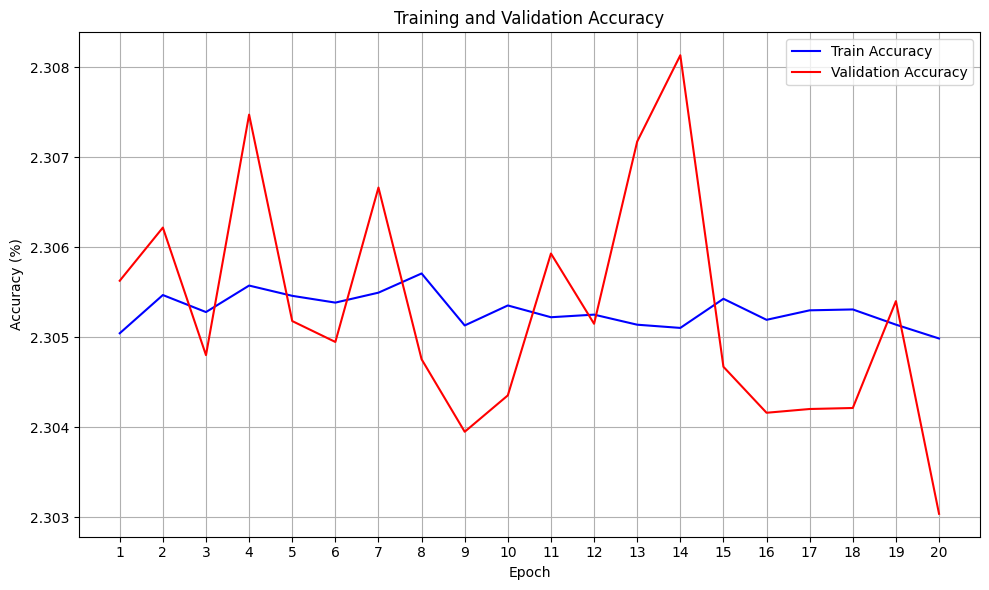

In [32]:
plot_accuracy(train_losses, val_losses)


I noticed that my implementation performs really bad. I think my model performs poorly because the architecture is simplicitic. Especially, I further reduce the pixelated (32, 32, 3) input image to (8, 8, 3).

This is the reason people use pretrained models, and so i will try to fine tune top five models that rank on the PyTorch leaderboard.

Before that, I want to try the exact implementation using Keras. I am eager whether I will get the same results.

In [37]:
import keras
from keras.applications import VGG16
from keras.layers import Input, Conv2D
from keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [39]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │         491,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 615,230 (2.35 MB)

 Trainable params: 615,230 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="crossentropy", optimizer=opt)

In [ ]:
model.fit()

# 2. Classification with transfer learning

In [ ]:
class InceptionV3(nn.Module):
    def __init__(self, list_of_classes, weights_path=None):
        super(InceptionV3, self).__init__()
        self.list_of_classes = list_of_classes
        self.num_classes = len(self.list_of_classes)
        self.base_model = self.load_inception(weights_path)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, self.num_classes)

    def forward(self, x):
          x = self.base_model(x)
          if isinstance(x, models.inception.InceptionOutputs):
              x = x.logits
          x = torch.sigmoid(x)
          return x

    def load_inception(self, weights_path):
        model = models.inception_v3(weights=None)
        if weights_path:
            print('Loading Weights')
            state_dict = torch.load(weights_path)
            model.load_state_dict(state_dict)
        return model


  3. Visualize some feature maps

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the intermediate layer (e.g., conv2d_1)
intermediate_layer = base_model.get_layer('block2_conv1')

# Create a new model that takes input and passes it through the intermediate layer
feature_map_model = Model(inputs=base_model.input, outputs=intermediate_layer.output)

# Compile the new model (dummy loss and optimizer)
feature_map_model.compile(loss='mse', optimizer='adam')

# Extract feature maps from input data
img = image.array_to_img(train_subset[3][0].permute(1, 2, 0).numpy(), scale=False)  # Convert to PIL Image, permute to (H, W, C) and convert to NumPy array
img = img.resize((224, 224))  # Resize the image
input_data = image.img_to_array(img)  # Convert back to NumPy array
input_data = input_data.reshape((1, 224, 224, 3))  # Add batch dimension

feature_maps = feature_map_model.predict(input_data)

The operation above is a demonstration of how we can visualize the features of a VGGNet - one of the CNNs variants.

The image reshaping operations happening so we can extract the features include reshaping the input image of the CIFAR 10 dataset (of shape 32,32,3) to (224,224,3) the shape of the input a VGGNet expects.

This image data is then passed to a feature map model whose inputs is similiar to what a VGGNet expects, and output is the output of our desired layer. By desired i mean the layer we want to visualize the pixels of regions the CNN focused on.

We can then visualize the outputs as in below.


In [ ]:
feature_maps.shape

In [ ]:
import matplotlib.pyplot as plt
for i, fmap in enumerate(feature_maps):
    plt.figure(figsize=(10, 5))  # Create a new figure for each feature map
    plt.subplot(1, 2, 1)  # Subplot 1: Original Image
    plt.imshow(img)  # Display the original image
    plt.title('Original Image')

    plt.subplot(1, 2, 2)  # Subplot 2: Feature Map
    plt.imshow(fmap[:, :, 1], cmap='gray')  # Visualize the first channel (filter)
    plt.title(f'Feature Map {i}')

    plt.show()
